In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 4.9 MB/s eta 0:00:00


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from fastai.vision.all import *

In [3]:
if Path("/kaggle").exists():
    data_path = Path("/kaggle", "input", "planets-dataset", "planet", "planet")
    output_path = Path("/kaggle", "working")
else:
    data_path = Path("planet", "planet")
    output_path = Path("artifacts")
    output_path.mkdir(exist_ok=True)

image_path = data_path / "train-jpg"
    

train_classes = pd.read_csv(data_path / "train_classes.csv")

In [4]:
train_classes["tag"] = (
    train_classes["tags"]
    .apply(
        lambda x: [tag for tag in x.split(" ") if tag != "selective_logging"]
    )
    .apply(
        lambda x: sorted(x)[-1]
    )
)

In [5]:
train_labels = {
    row["image_name"]: row["tag"] for i, row in train_classes.iterrows()
}

In [6]:
train_classes.tag.value_counts()

primary          24708
water             7411
road              5915
cloudy            2089
slash_burn         185
clear              127
partly_cloudy       23
haze                12
habitation           7
cultivation          2
Name: tag, dtype: int64

In [7]:
train_classes.query("tag == 'cloudy'").head()

,image_name,tags,tag
12,train_12,cloudy,cloudy
14,train_14,cloudy,cloudy
26,train_26,cloudy,cloudy
50,train_50,cloudy,cloudy
68,train_68,cloudy,cloudy


In [8]:
def show_image(image_name):
    img = plt.imread(data_path / "train-jpg" / f"{image_name}.jpg")
    # Add label as title
    plt.title(train_labels[image_name])
    plt.imshow(img)
    plt.axis("off")
    plt.show()

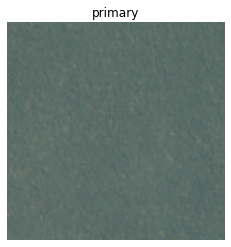

In [9]:
show_image("train_0")

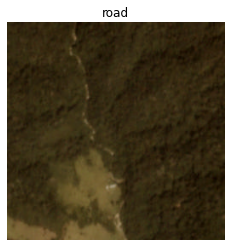

In [10]:
show_image("train_4")

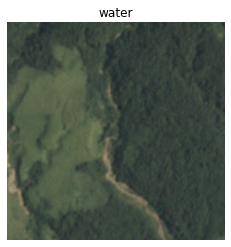

In [11]:
show_image("train_1")

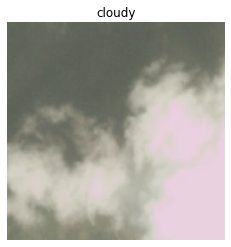

In [12]:
show_image("train_12")

In [13]:
def label(file_name):
    return train_labels[file_name.replace(".jpg", "")]

In [14]:
label("train_30370.jpg")

'primary'

In [15]:
f1_macro = F1Score(average='macro')
f1_micro = F1Score(average='micro')
# f1_macro.name = 'F1(macro)'
# f1_micro.name = 'F1(micro)'


In [16]:
dls = ImageDataLoaders.from_name_func(
    image_path,
    get_image_files(image_path),
    valid_pct=0.2,
    seed=42,
    label_func=label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224)
)

In [17]:
# if a string is passed into the model argument, it will now use timm (if it is installed)
learn = vision_learner(
    dls,
    'vit_tiny_patch16_224',
    metrics=[error_rate, f1_macro, f1_micro],
    model_dir=output_path
)

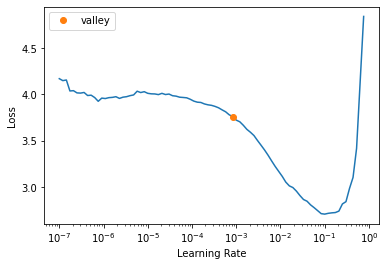

In [18]:
lr = learn.lr_find()

In [19]:
learn.fine_tune(10, lr.valley)

epoch,train_loss,valid_loss,error_rate,f1_score,f1_score,time
0,0.797379,0.544448,0.153799,0.358584,0.846201,04:41


epoch,train_loss,valid_loss,error_rate,f1_score,f1_score,time
0,0.672523,0.454394,0.137986,0.375768,0.862014,03:56
1,0.490460,0.395495,0.127116,0.386445,0.872884,03:55
2,0.437446,0.358747,0.121680,0.397898,0.878320,03:54
3,0.396432,0.342638,0.121062,0.403665,0.878938,03:54
4,0.377234,0.333996,0.118839,0.400377,0.881161,03:56
5,0.357414,0.328649,0.116121,0.407664,0.883879,03:57
6,0.370650,0.325863,0.113774,0.414593,0.886226,03:54
7,0.371539,0.325886,0.115380,0.405782,0.884620,03:53
8,0.335125,0.325264,0.113897,0.412367,0.886103,03:53
9,0.321865,0.325347,0.113897,0.406530,0.886103,03:53


In [20]:
learn.validate()

(#4) [0.3253469467163086,0.11389746516942978,0.40653049571915134,0.8861025324274243]

In [21]:
predictions, targets = learn.get_preds()

In [22]:
predictions_tta, targets_tta = learn.tta()

In [23]:
f1_score(
    targets,
    np.argmax(np.array(predictions), axis=1),
    average='macro'
)


0.40653049571915134

In [24]:
f1_score(
    targets,
    np.argmax(np.array(predictions_tta), axis=1),
    average='macro'
)

0.40519761181452363

In [25]:
# Export learned model in predatathon folder
learn.export(output_path / "model.pkl")

In [26]:
image_name = "train_0"
img = plt.imread(data_path / "train-jpg" / f"{image_name}.jpg")[:,:,:-1]
# img = PILImage.create(img)
learn.predict(img)


('primary',
 tensor(6),
 tensor([7.1408e-05, 4.2293e-04, 2.8372e-06, 6.2188e-06, 7.1596e-06, 1.2730e-05,
         9.9742e-01, 1.2057e-03, 1.0896e-04, 7.4317e-04]))

In [27]:
learn_loaded = load_learner(output_path / "model.pkl")

In [28]:
learn_loaded.predict(img)

('primary',
 tensor(6),
 tensor([7.1408e-05, 4.2293e-04, 2.8372e-06, 6.2188e-06, 7.1596e-06, 1.2730e-05,
         9.9742e-01, 1.2057e-03, 1.0896e-04, 7.4316e-04]))

In [29]:
! pip list | grep "torch"

pytorch-ignite                        0.4.10
pytorch-lightning                     1.7.7
torch                                 1.11.0
torchaudio                            0.11.0
torchmetrics                          0.10.0
torchtext                             0.12.0
torchvision                           0.12.0
